# Linear Baseline: Logistic Regression on DenseNet121 Features

Train a per-pathology logistic regression independently on CheXpert and NIH, each with their own 80/20 train/test split, and report AUC on each dataset's held-out test set.

In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from wcp_l2d.features import ExtractedFeatures
from wcp_l2d.pathologies import COMMON_PATHOLOGIES

## 1. Load extracted features

In [11]:
FEATURE_DIR = Path("../data/features")

chexpert = ExtractedFeatures.load(
    FEATURE_DIR / "chexpert_densenet121-res224-chex_features.npz"
)
nih = ExtractedFeatures.load(FEATURE_DIR / "nih_densenet121-res224-chex_features.npz")

print(
    f"CheXpert: {chexpert.features.shape[0]:,} samples, {chexpert.features.shape[1]} features"
)
print(f"NIH:      {nih.features.shape[0]:,} samples, {nih.features.shape[1]} features")
print(f"Pathologies: {COMMON_PATHOLOGIES}")

CheXpert: 64,534 samples, 1024 features
NIH:      30,805 samples, 1024 features
Pathologies: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Pneumonia', 'Pneumothorax']


## 2. Train/test split (80/20 each dataset independently)

In [6]:
datasets = {}

for name, data in [("CheXpert", chexpert), ("NIH", nih)]:
    X_tr, X_te, y_tr, y_te = train_test_split(
        data.features, data.labels, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.transform(X_te)
    datasets[name] = {"X_train": X_tr, "X_test": X_te, "y_train": y_tr, "y_test": y_te}
    print(f"{name:10s}  train={X_tr.shape[0]:>6,}  test={X_te.shape[0]:>6,}")

CheXpert    train=51,627  test=12,907
NIH         train=24,644  test= 6,161


## 3. Train per-pathology logistic regression & evaluate AUC

In [16]:
results = []

for ds_name, ds in datasets.items():
    print(f"\n--- {ds_name} ---")
    for i, pathology in enumerate(COMMON_PATHOLOGIES):
        y_tr = ds["y_train"][:, i]
        y_te = ds["y_test"][:, i]

        y_tr_positive = np.nansum(y_tr == 1)
        y_te_positive = np.nansum(y_te == 1)

        train_mask = ~np.isnan(y_tr)
        test_mask = ~np.isnan(y_te)

        y_tr_clean = y_tr[train_mask]
        X_tr_clean = ds["X_train"][train_mask]

        if len(np.unique(y_tr_clean)) < 2:
            print(f"  {pathology}: skipped (single class in train)")
            results.append(
                {
                    "dataset": ds_name,
                    "pathology": pathology,
                    "n_train": len(y_tr_clean),
                    "n_test": int(test_mask.sum()),
                    "auc": np.nan,
                }
            )
            continue

        clf = LogisticRegression(max_iter=1000, solver="lbfgs", C=1.0, random_state=42)
        clf.fit(X_tr_clean, y_tr_clean)

        auc = np.nan
        if test_mask.sum() > 0 and len(np.unique(y_te[test_mask])) >= 2:
            probs = clf.predict_proba(ds["X_test"][test_mask])[:, 1]
            auc = roc_auc_score(y_te[test_mask], probs)

        results.append(
            {
                "dataset": ds_name,
                "pathology": pathology,
                "n_train": int(train_mask.sum()),
                "n_test": int(test_mask.sum()),
                "auc": auc,
            }
        )
        print(
            f"  {pathology:20s}  train={train_mask.sum():>6,} train positive={y_tr_positive:>6,}  test={test_mask.sum():>6,} test positive={y_te_positive:>6,}  AUC={auc:.4f}"
        )


--- CheXpert ---
  Atelectasis           train=21,610 train positive=10,171  test= 5,398 test positive= 2,520  AUC=0.8012
  Cardiomegaly          train=21,495 train positive= 7,295  test= 5,369 test positive= 1,804  AUC=0.8725
  Consolidation         train=22,266 train positive= 4,329  test= 5,628 test positive= 1,061  AUC=0.8571
  Edema                 train=28,352 train positive=11,901  test= 7,192 test positive= 3,028  AUC=0.8437
  Effusion              train=35,283 train positive=16,514  test= 8,857 test positive= 4,126  AUC=0.8799
  Pneumonia             train=14,097 train positive= 2,263  test= 3,518 test positive=   559  AUC=0.7788
  Pneumothorax          train=29,652 train positive= 3,463  test= 7,344 test positive=   848  AUC=0.7316

--- NIH ---
  Atelectasis           train=24,644 train positive= 1,323  test= 6,161 test positive=   342  AUC=0.7301
  Cardiomegaly          train=24,644 train positive=   613  test= 6,161 test positive=   164  AUC=0.8609
  Consolidation         

## 4. Summary table

In [8]:
df = pd.DataFrame(results)

# Pivot for side-by-side comparison
pivot = df.pivot(index="pathology", columns="dataset", values="auc")
pivot = pivot.reindex(COMMON_PATHOLOGIES)
pivot.loc["Macro Avg"] = pivot.mean()

pivot.style.format("{:.4f}").set_caption(
    "Linear baseline AUC (Logistic Regression on DenseNet121 features)"
)

dataset,CheXpert,NIH
pathology,,
Atelectasis,0.8012,0.7301
Cardiomegaly,0.8725,0.8609
Consolidation,0.8571,0.6710
Edema,0.8437,0.7143
Effusion,0.8799,0.7950
Pneumonia,0.7788,0.6195
Pneumothorax,0.7316,0.6039
Macro Avg,0.8235,0.7135


## 5. Visualization

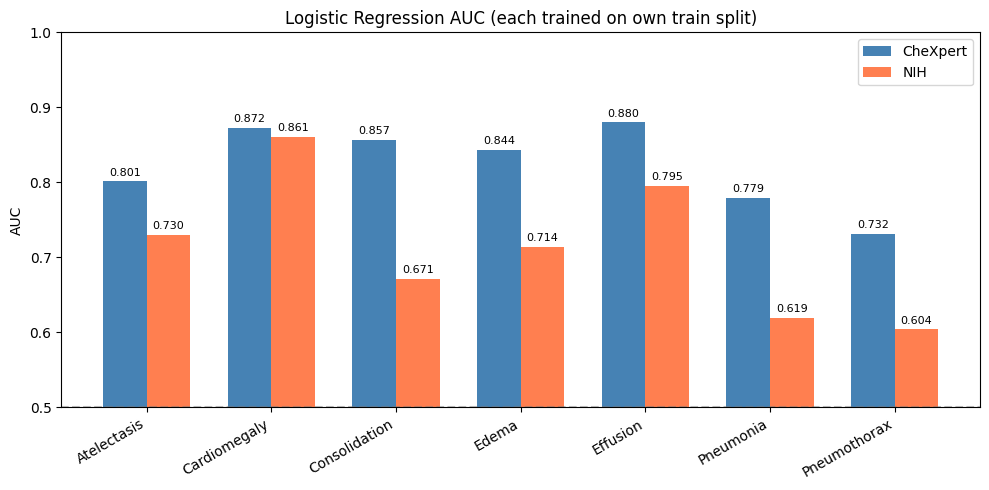

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(COMMON_PATHOLOGIES))
width = 0.35

auc_chex = pivot.loc[COMMON_PATHOLOGIES, "CheXpert"].values
auc_nih = pivot.loc[COMMON_PATHOLOGIES, "NIH"].values

bars1 = ax.bar(x - width / 2, auc_chex, width, label="CheXpert", color="steelblue")
bars2 = ax.bar(x + width / 2, auc_nih, width, label="NIH", color="coral")

ax.set_ylabel("AUC")
ax.set_title("Logistic Regression AUC (each trained on own train split)")
ax.set_xticks(x)
ax.set_xticklabels(COMMON_PATHOLOGIES, rotation=30, ha="right")
ax.legend()
ax.set_ylim(0.5, 1.0)
ax.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5)

for bar in bars1:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.005,
        f"{bar.get_height():.3f}",
        ha="center",
        va="bottom",
        fontsize=8,
    )
for bar in bars2:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.005,
        f"{bar.get_height():.3f}",
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.tight_layout()
plt.show()